In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
# define train and test path

train_dir = "/kaggle/input/fer2013/train" #passing the path with training images

test_dir = "/kaggle/input/fer2013/test"   #passing the path with testing images

In [37]:
# import libray

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization ,Activation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import itertools

In [19]:
img_size = 48

In [20]:

# Data Augmentation
# --------------------------
# rotation_range = rotates the image with the amount of degrees we provide
# width_shift_range = shifts the image randomly to the right or left along the width of the image
# height_shift range = shifts image randomly to up or below along the height of the image
# horizontal_flip = flips the image horizontally
# rescale = to scale down the pizel values in our image between 0 and 1
# zoom_range = applies random zoom to our object
# validation_split = reserves some images to be used for validation purpose


train_datagen = ImageDataGenerator( horizontal_flip = True,
                                    brightness_range=(0.2,1.0),
                                    rescale=1./255,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split = 0.2
                                    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
batch_size=64

In [22]:
"""
Applying data augmentation to the images as we read 
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = batch_size,
                                                    # color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    seed=42,
                                                    subset = "training"
                                                   )
validation_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = batch_size,
                                                    # color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    seed=42,
                                                    subset = "validation"
                                                   )

#test data
test_generator = test_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = batch_size,
                                                              # color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              shuffle=False
                                                             )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# from sklearn.utils import class_weight
# Compute class weights to balance the classes
class_weights = dict(zip(range(7), (np.sum(train_generator.classes == i) for i in range(7))))
total_samples = np.sum(list(class_weights.values()))
for key in class_weights: #0-6
    class_weights[key] = (1 / class_weights[key]) * (total_samples / 7)

In [24]:
# to plot the validation dataset confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
target_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [26]:
#create callbacl list for model training
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', 
                               min_delta = 0.00005, 
                               patience = 10,
                               verbose = 1, 
                               restore_best_weights = True,)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_categorical_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks_list = [early_stopping, reduce_learningrate]
epochs = 50

# [RESNET50+Softmax]

In [27]:
base_model = ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

94765736/94765736 [==============================] - 1s 0us/step


In [28]:
# Building Model

model=Sequential()
model.add(base_model)

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(7,activation='softmax'))

In [29]:
epochs = 60
batch_size = 64

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 32)               

In [31]:
model.compile(
    optimizer = Adam(learning_rate = 0.0001), 
    loss='categorical_crossentropy', 
    metrics=METRICS, 
)

In [32]:
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    epochs = epochs,
                    verbose = 1,
                    callbacks=callbacks_list,
                    class_weight=class_weights)

Epoch 1/60
359/359 [==============================] - 72s 182ms/step - loss: 2.0370 - accuracy: 0.0000e+00 - binary_accuracy: 0.8557 - categorical_accuracy: 0.1772 - precision: 0.1813 - recall: 0.0029 - auc: 0.5811 - val_loss: 1.9709 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8569 - val_categorical_accuracy: 0.1352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5298 - lr: 1.0000e-04
Epoch 2/60
359/359 [==============================] - 63s 175ms/step - loss: 1.9500 - accuracy: 0.0000e+00 - binary_accuracy: 0.8570 - categorical_accuracy: 0.1978 - precision: 0.3333 - recall: 6.9662e-04 - auc: 0.5954 - val_loss: 1.9227 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8561 - val_categorical_accuracy: 0.1998 - val_precision: 0.2267 - val_recall: 0.0030 - val_auc: 0.6154 - lr: 1.0000e-04
Epoch 3/60
359/359 [==============================] - 64s 178ms/step - loss: 1.9299 - accuracy: 0.0000e+00 - binary_accuracy: 0.8570 - categorical_accuracy: 0.2078 - precision:

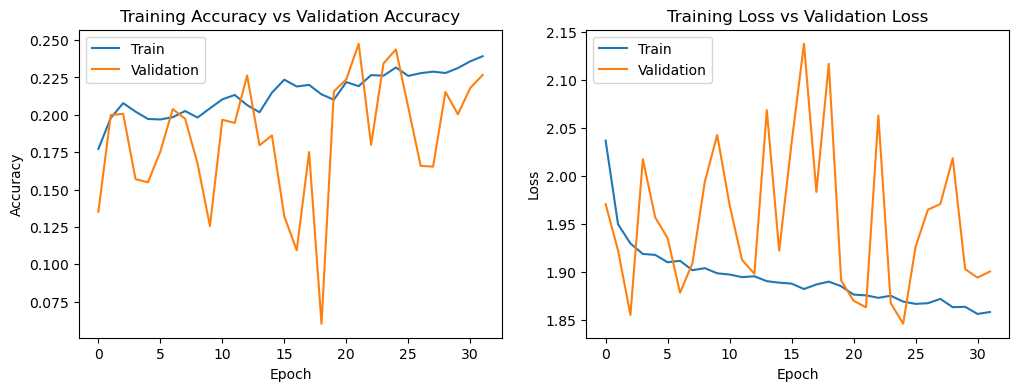

In [33]:
#visualize
fig , ax = plt.subplots(1,2)
train_acc = history.history["categorical_accuracy"]
train_loss = history.history["loss"]
fig.set_size_inches(12,4)

ax[0].plot(history.history["categorical_accuracy"])
ax[0].plot(history.history["val_categorical_accuracy"])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

113/113 - 7s - 7s/epoch - 63ms/step


              precision    recall  f1-score   support

       Angry       0.20      0.36      0.26       958
     Disgust       0.03      0.31      0.06       111
        Fear       0.25      0.08      0.12      1024
       Happy       0.37      0.47      0.41      1774
     Neutral       0.36      0.08      0.13      1233
         Sad       0.32      0.13      0.19      1247
    Surprise       0.35      0.45      0.39       831

    accuracy                           0.27      7178
   macro avg       0.27      0.27      0.22      7178
weighted avg       0.31      0.27      0.26      7178

n
Normalized confusion matrix
[[0.35908142 0.17745303 0.0480167  0.23382046 0.03340292 0.05741127
  0.0908142 ]
 [0.23423423 0.30630631 0.05405405 0.27927928 0.01801802 0.03603604
  0.07207207]
 [0.21484375 0.13476562 0.08105469 0.2578125  0.02734375 0.06640625
  0.21777344]
 [0.21589628 0.1042841  0.02874859 0.4746336  0.02931229 0.05580609
  0.09131905]
 [0.219

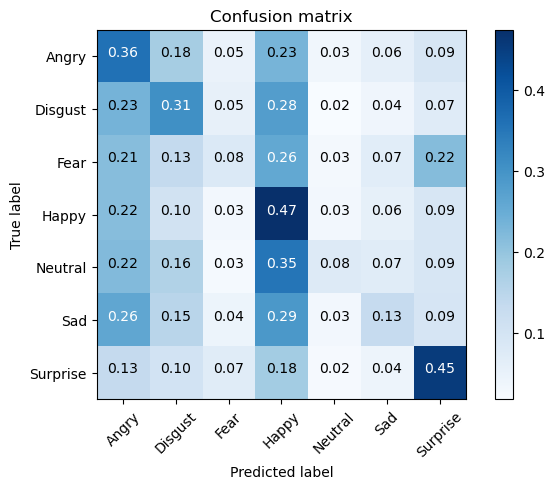

In [38]:
Y_pred_2 = model.predict(test_generator, verbose=2)
y_pred_2 = np.argmax(Y_pred_2, axis=1)
print('\n')
print(classification_report(test_generator.classes, y_pred_2, target_names=target_names))
print('n')
cm = confusion_matrix(test_generator.classes, y_pred_2)
plot_confusion_matrix(cm, classes=target_names, normalize=True)

In [56]:
model.evaluate(test_generator)

113/113 [==============================] - 8s 67ms/step - loss: 1.8495 - accuracy: 0.0000e+00 - binary_accuracy: 0.8564 - categorical_accuracy: 0.2703 - precision: 0.4490 - recall: 0.0215 - auc: 0.6512


[1.8494787216186523,
 0.0,
 0.8564462661743164,
 0.2702702581882477,
 0.44897958636283875,
 0.021454444155097008,
 0.6512326002120972]

In [52]:
model.save('resnet_base.h5')
model.save('/kaggle/working/resnet_base.h5')

# [RESNET50+Dropout+Softmax]

In [40]:
base_model2 = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [43]:
# Building model2

model2=Sequential()
model2.add(base_model2)
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(32,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(7,activation='softmax'))

In [44]:
# Model Summary

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_6 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                      

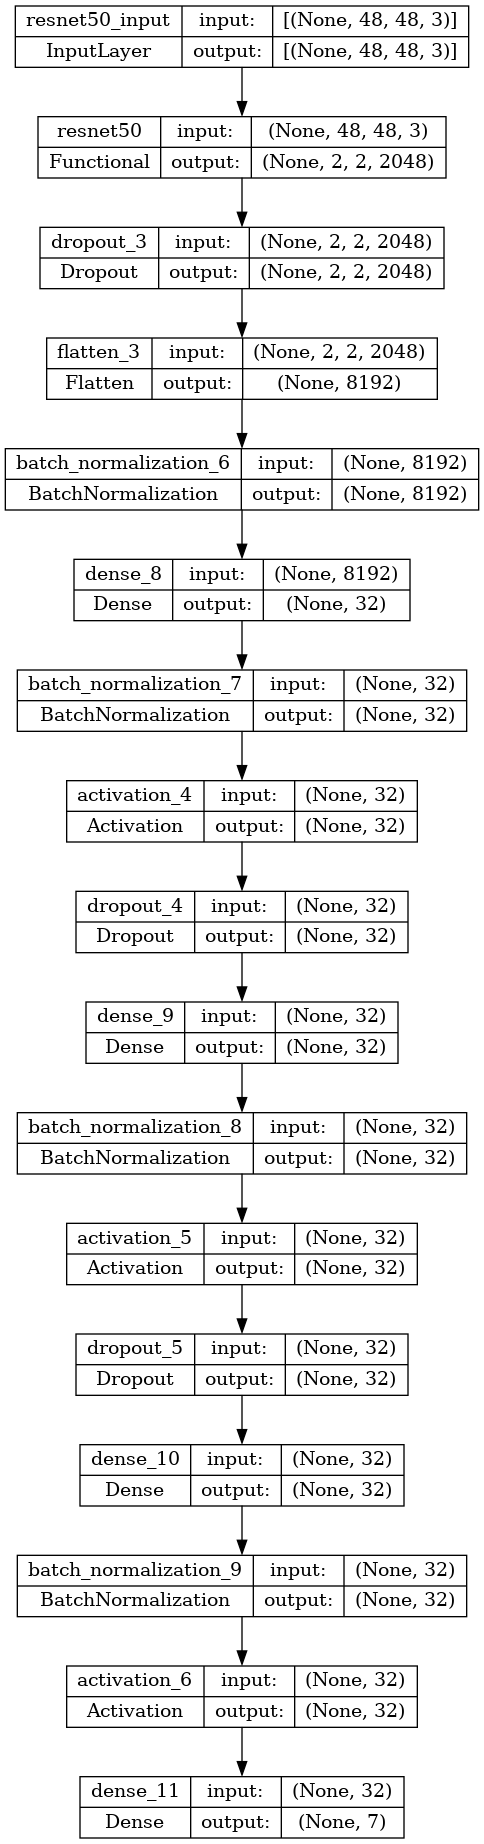

In [45]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model2, to_file='RESNET50_drop_convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='RESNET50_drop_convnet.png') 

In [46]:
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=METRICS)

In [47]:
history2 = model2.fit(train_generator, 
                    validation_data=validation_generator,
                    epochs = epochs,
                    verbose = 1,
                    callbacks=callbacks_list,
                    class_weight=class_weights)

Epoch 1/60


2023-04-23 03:30:53.952808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


359/359 [==============================] - 129s 254ms/step - loss: 2.1641 - accuracy: 0.0000e+00 - binary_accuracy: 0.8513 - categorical_accuracy: 0.1264 - precision: 0.1475 - recall: 0.0085 - auc: 0.4762 - val_loss: 23.3063 - val_accuracy: 6.4698e-04 - val_binary_accuracy: 0.7540 - val_categorical_accuracy: 0.1392 - val_precision: 0.1392 - val_recall: 0.1392 - val_auc: 0.4984 - lr: 1.0000e-04
Epoch 2/60
359/359 [==============================] - 68s 190ms/step - loss: 2.0889 - accuracy: 0.0000e+00 - binary_accuracy: 0.8530 - categorical_accuracy: 0.1073 - precision: 0.1519 - recall: 0.0064 - auc: 0.4659 - val_loss: 2.0202 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8571 - val_categorical_accuracy: 0.0152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4091 - lr: 1.0000e-04
Epoch 3/60
359/359 [==============================] - 71s 196ms/step - loss: 2.0546 - accuracy: 0.0000e+00 - binary_accuracy: 0.8533 - categorical_accuracy: 0.1160 - precision: 0.1845 - rec

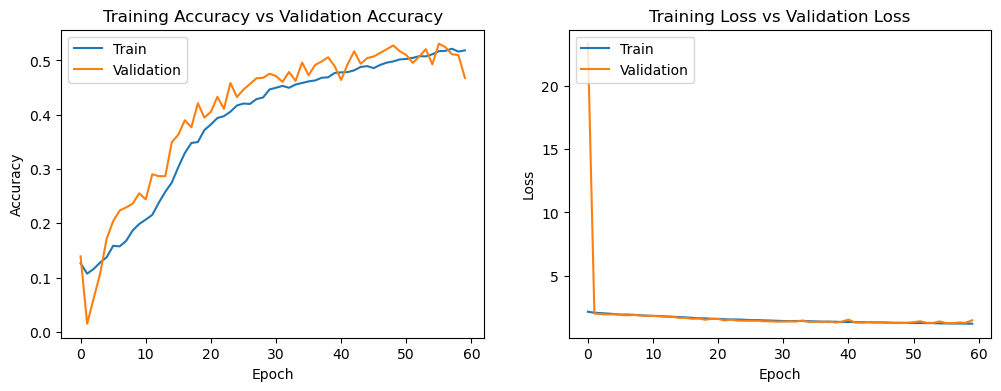

In [49]:
#visualize
fig , ax = plt.subplots(1,2)
train_acc = history2.history["categorical_accuracy"]
train_loss = history2.history["loss"]
fig.set_size_inches(12,4)

ax[0].plot(history2.history["categorical_accuracy"])
ax[0].plot(history2.history["val_categorical_accuracy"])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

113/113 - 14s - 14s/epoch - 121ms/step


              precision    recall  f1-score   support

       Angry       0.26      0.47      0.33       958
     Disgust       0.19      0.64      0.29       111
        Fear       0.28      0.14      0.19      1024
       Happy       0.97      0.44      0.61      1774
     Neutral       0.49      0.30      0.37      1233
         Sad       0.33      0.61      0.43      1247
    Surprise       0.73      0.61      0.67       831

    accuracy                           0.43      7178
   macro avg       0.46      0.46      0.41      7178
weighted avg       0.54      0.43      0.44      7178

n
Normalized confusion matrix
[[0.46659708 0.11377871 0.04384134 0.00313152 0.03862213 0.32150313
  0.0125261 ]
 [0.18018018 0.63963964 0.01801802 0.         0.         0.14414414
  0.01801802]
 [0.28710938 0.05175781 0.140625   0.00195312 0.04492188 0.36425781
  0.109375  ]
 [0.25760992 0.02480271 0.0270575  0.44081172 0.09131905 0.14261556
  0.01578354]
 [0.

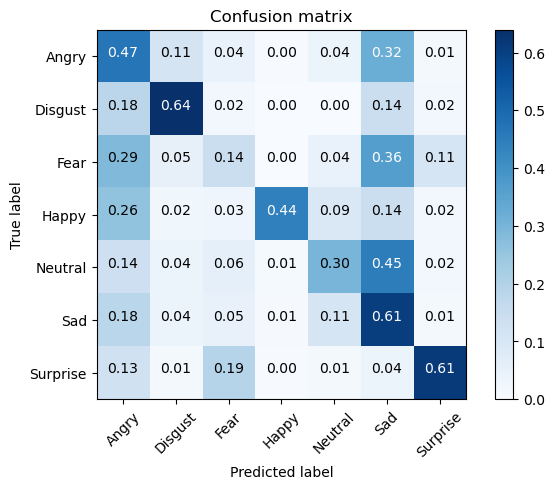

In [50]:
Y_pred_2 = model2.predict(test_generator, verbose=2)
y_pred_2 = np.argmax(Y_pred_2, axis=1)
print('\n')
print(classification_report(test_generator.classes, y_pred_2, target_names=target_names))
print('n')
cm = confusion_matrix(test_generator.classes, y_pred_2)
plot_confusion_matrix(cm, classes=target_names, normalize=True)

In [55]:
model2.evaluate(test_generator)

113/113 [==============================] - 10s 91ms/step - loss: 1.6612 - accuracy: 0.0000e+00 - binary_accuracy: 0.8737 - categorical_accuracy: 0.4288 - precision: 0.7906 - recall: 0.1573 - auc: 0.7666


[1.6611748933792114,
 0.0,
 0.8736615777015686,
 0.4288102388381958,
 0.7906162738800049,
 0.1572861522436142,
 0.7666178345680237]

In [54]:
model2.save('resnet_dropout.h5')
model2.save('/kaggle/working/resnet_dropout.h5')